## 预处理

In [34]:
import os
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import numpy as np
from matplotlib.font_manager import FontProperties
import html



In [35]:
MEDBENCH_PATH = './data/MedBench'

LORA_HUATUO_26M_LITE_PATH = os.path.join(MEDBENCH_PATH, 'lora_huatuo_26m_lite')

datasets_path_list = os.path.join(LORA_HUATUO_26M_LITE_PATH, 'MedHC_test.jsonl')

METRICS_PATH = os.path.join(MEDBENCH_PATH, 'metrics.json')

model_list = ['GLM4-9B-chat', 'MedGLM_lora_huatuo_26m_lite', 'MedGLM_lora_huatuo_sft_data_v1']

In [36]:
# 加载数据

with open(METRICS_PATH, 'r', encoding='utf-8') as f:
    metrics = json.load(f)


In [37]:
def plot_model_overall_scores(metrics):
    
    # 从metrics中提取tasks和models
    tasks = list(metrics[next(iter(metrics))].keys())
    models = list(metrics.keys())

    # 计算每个模型在每个任务上的得分
    scores = {model: [metrics[model][task] if isinstance(metrics[model][task], (int, float)) 
                       else metrics[model][task].get("Score", 0) 
                       for task in tasks] for model in models}

    # 创建图表
    x = np.arange(len(tasks))
    width = 0.2

    fig, ax = plt.subplots()

    # 创建柱状图并保存每个模型的rects
    bars = []
    for i, model in enumerate(models):
        bars.append(ax.bar(x + i * width, scores[model], width, label=model))

    # 在每根柱子上方添加数值标签
    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, round(height, 1), ha='center', va='bottom')

    ax.set_xlabel('Task')
    ax.set_ylabel('Score')
    ax.set_title('Overall performance of different models on MedBench-related medical tasks')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=15)
    ax.legend()

    fig.tight_layout()
    plt.show()

In [38]:
def plot_model_scores(metric, task_name):
    # 提取模型和数据集信息
    models = list(metric.keys())
    datasets = list(metric[models[0]][task_name].keys())

    # 提取分数
    scores = {model: [metric[model][task_name][dataset] for dataset in datasets] for model in models}

    x = np.arange(len(datasets))

    fig, ax = plt.subplots()

    # 创建折线图并保存每个模型的line
    lines = []
    for model in models:
        line, = ax.plot(x, scores[model], marker='o', label=model)
        lines.append(line)

    # 在每个点上方添加数值标签
    for model in models:
        for i, score in enumerate(scores[model]):
            ax.text(x[i], score, round(score, 1),  # 使用round函数保留一位小数
                    ha='center', va='bottom', rotation=0)  # type: ignore

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Score')
    title = f'The performance of models in the [{task_name}] task'
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=15)
    ax.legend()  

    fig.tight_layout()
    plt.show()


In [39]:
def display_qa_slider(model_list, dataset):

    data_dir = 'data/MedBench'

    # 读取数据
    data = {}
    for model in model_list:
        data[model] = []
        with open(os.path.join(data_dir, model, dataset + '.jsonl'), 'r', encoding='utf-8') as f:
            for line in f:
                data[model].append(json.loads(line.strip()))

    # 创建滑块
    slider = widgets.IntSlider(
        min=0,
        max=len(data[model_list[0]]) - 1,
        step=1,
        description=f'共{len(data[model_list[0]])}:',
        continuous_update=True
    )

    # 创建文本区域来显示问题和答案
    output = widgets.Output()

    # 定义一个内部函数来显示问题和答案
    def display_qa(index):
        with output:
            clear_output()  # 清除之前的输出
            question = data[model_list[0]][index]['question']
            question_escaped = html.escape(question)
            display(HTML(f"<h1> {dataset} </h1>"))
            display(HTML(f"<h2 style='text-align: center;'>Question</h2><p style='white-space: pre-wrap;'><strong>{question_escaped}</strong></p>"))
            display(HTML(f"<h2 style='text-align: center;'>Answer</h2>"))
            for model in model_list:
                answer = data[model][index]['answer']
                answer_escaped = html.escape(answer)
                display(HTML(f"<h3>{model}:</h3><p style='white-space: pre-wrap;'>{answer_escaped}</p>"))

    # 绑定滑块的变化事件
    def slider_changed(change):
        display_qa(change.new)

    slider.observe(slider_changed, names='value')

    # 显示滑块和文本区域
    display(slider, output)

    # 初始化显示第一个QA对
    display_qa(0)

## 一、不同模型在医疗相关任务上的整体表现

### 5个评测维度能力的得分与综合得分的计算

**得分归一化**。为了解决不同数据集上得分尺度不一致的问题，平衡各子任务的难度，我们对各任务得分进行了统一的尺度放缩，利用线性变换将各数据集上的得分放缩到确定的范围。（具体而言，我们预先选取了五个LLM，包括GPT-4-1106，GPT-3.5-1106，Dayi，PULSE和DoctorGLM。我们将其中每个数据集上最优的模型得分约定为80基准分数，将最低分数约定为0基准分数，得到线性变换的权重w，并基于该线性变换得到归一化后的得分。）

**评价指标**。为了全面评估大型模型在医疗领域的性能，我们采取了基于各数据集得分的调和平均数作为评价标准。此方法旨在平衡极端分数的影响，奖励那些在多个数据集上表现稳定的模型。通过此评价机制，我们可以更精确地衡量模型的整体表现，并激励开发者优化模型在所有数据集中的性能。


### 模型说明

GLM4-9B-Chat: 基座模型 

**MedGLM**_lora_huatuo_26m_lite：使用Huatuo26M-Lite数据集进行Lora微调。 

**MedGLM**_lora_huatuo_sft_data_v1：使用Huatuo-SFT-Data-V1数据集进行Lora微调。 


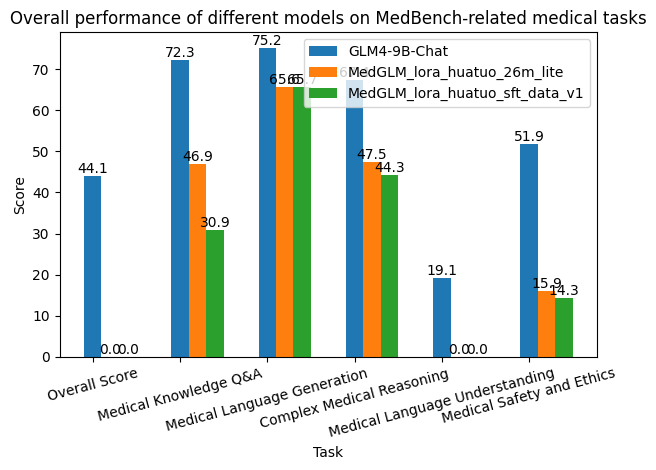

In [40]:
plot_model_overall_scores(metrics)

## 二、在【医疗知识问答】任务上的表现

### 1. 在医疗知识问答任务上的评分

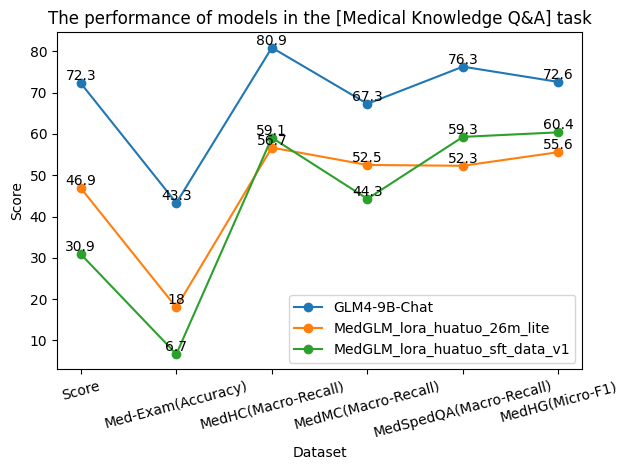

In [41]:
plot_model_scores(metrics, "Medical Knowledge Q&A") # type: ignore

### 2. 在各数据集上的具体表现

通过操作滑动条，可以查看各模型在该数据集上所有样本的问答结果。

In [42]:
dataset = 'Med-Exam_test'
display_qa_slider(model_list, dataset) 

IntSlider(value=0, description='共742:', max=741)

Output()

In [43]:
dataset = 'MedHC_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

In [44]:
dataset = 'MedMC_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

In [45]:
dataset = 'MedSpeQA_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

In [46]:
dataset = 'MedHG_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共74:', max=73)

Output()

## 三、在【医学语言生成】任务上的表现

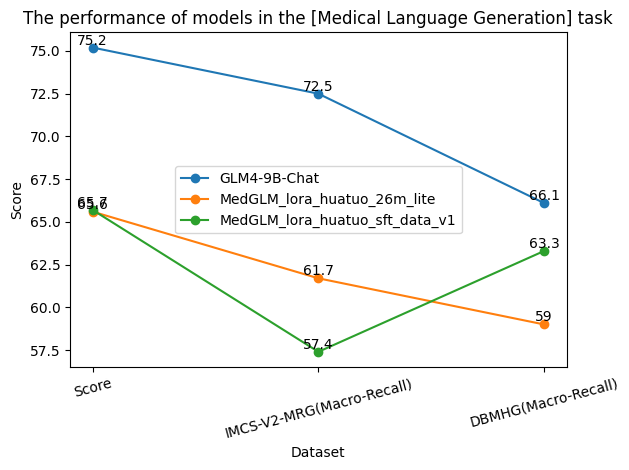

In [47]:
plot_model_scores(metrics, "Medical Language Generation") # type: ignore

In [48]:
dataset = 'IMCS-V2-MRG_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共49:', max=48)

Output()

In [49]:
dataset = 'DBMHG_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共49:', max=48)

Output()

## 四、在【复杂医学推理】任务上的表现

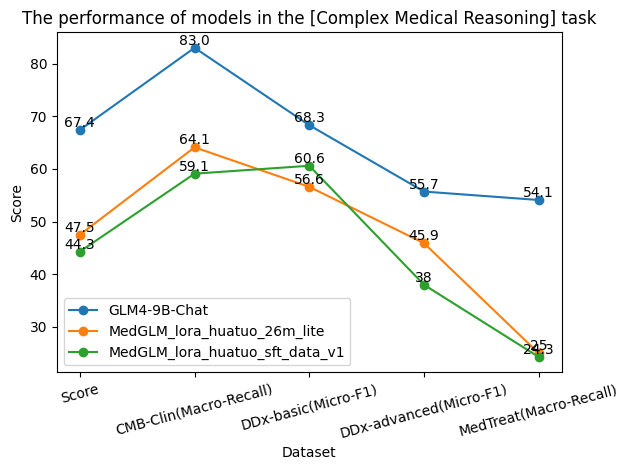

In [50]:
plot_model_scores(metrics, "Complex Medical Reasoning") # type: ignore

In [51]:
dataset = 'CMB-Clin_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共30:', max=29)

Output()

In [52]:
dataset = 'DDx-basic_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

In [53]:
dataset = 'DDx-advanced_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共29:', max=28)

Output()

In [54]:
dataset = 'MedTreat_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

## 五、在【医学语言理解】任务上的表现

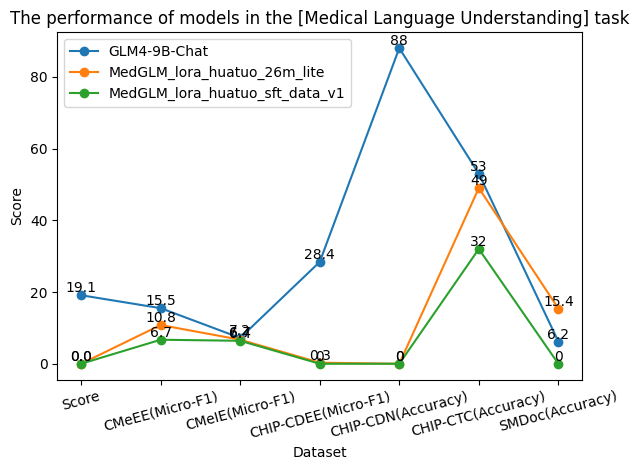

In [55]:
plot_model_scores(metrics, "Medical Language Understanding") # type: ignore

In [56]:
dataset = 'CMeEE_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共100:', max=99)

Output()

In [57]:
dataset = 'CMeIE_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共100:', max=99)

Output()

In [58]:
dataset = 'CHIP-CDEE_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共100:', max=99)

Output()

In [59]:
dataset = 'CHIP-CDN_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

In [60]:
dataset = 'CHIP-CTC_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共100:', max=99)

Output()

In [61]:
dataset = 'SMDoc_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共50:', max=49)

Output()

## 六、在【医疗安全和伦理】任务上的表现

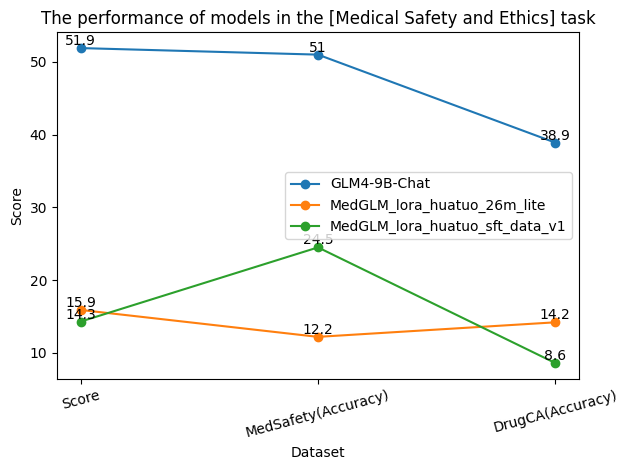

In [62]:
plot_model_scores(metrics, "Medical Safety and Ethics") # type: ignore

In [63]:
dataset = 'MedSafety_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共230:', max=229)

Output()

In [64]:
dataset = 'DrugCA_test'
display_qa_slider(model_list, dataset) # type: ignore

IntSlider(value=0, description='共354:', max=353)

Output()